Saved -> byrd_multipart_figure.png and byrd_multipart_figure.pdf


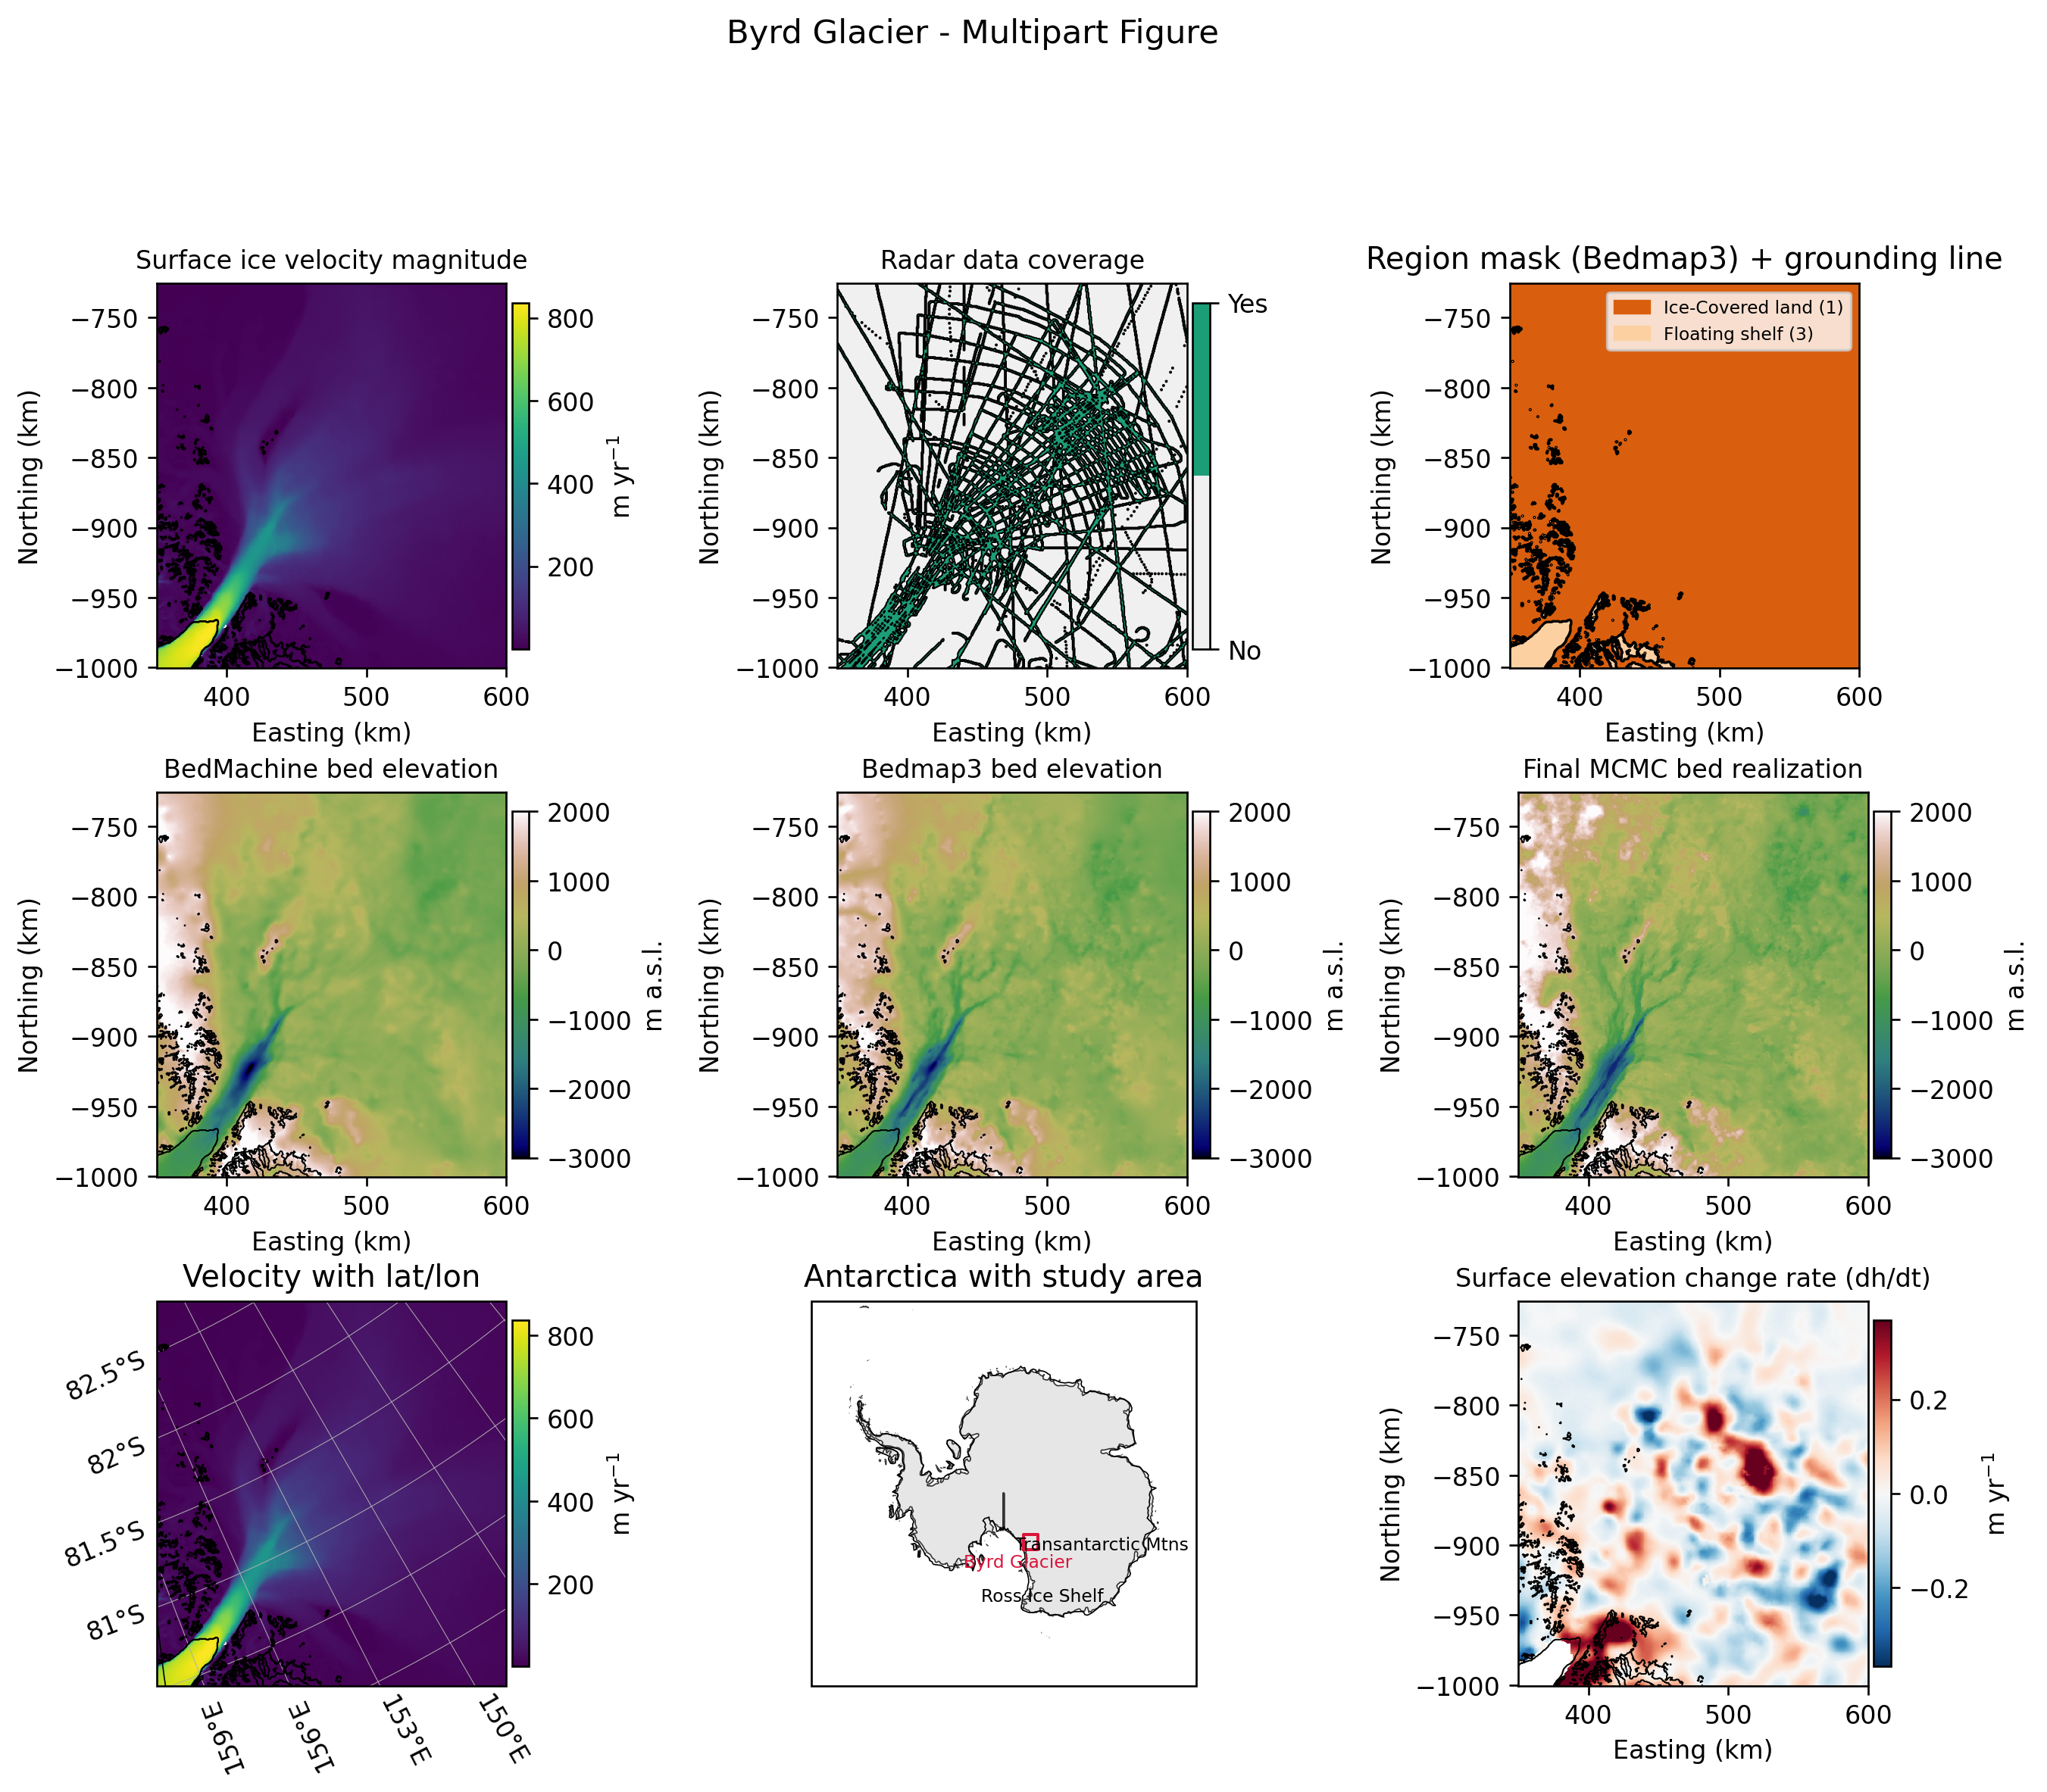

In [12]:
# BYRD GLACIER MULTIPART FIGURE

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import CRS, Transformer
import cmocean

try:
    import gstatsim as gst
except Exception:
    gst = None
from scipy.ndimage import gaussian_filter

GL_DIR = "./moa2014_groundingline_v01"  
GL_SHP = os.path.join(GL_DIR, "moa2014_grounding_line_v01.shp")

df = pd.read_csv("ByrdGlacierDataGridded.csv")
xx, yy = np.meshgrid(np.unique(df.x), np.unique(df.y))

XK, YK = xx/1000.0, yy/1000.0

# Field reshapes
surf            = df['surf'].values.reshape(xx.shape)
bedmap_bed      = df['bedmap_bed'].values.reshape(xx.shape)
bm_thick        = df['bedmachine_thickness'].values.reshape(xx.shape)
velx            = df['velx'].values.reshape(xx.shape)
vely            = df['vely'].values.reshape(xx.shape)
smb             = df['smb'].values.reshape(xx.shape)
dhdt            = df['dhdt'].values.reshape(xx.shape)
bedmap_mask_raw = df['bedmap_mask'].values.reshape(xx.shape)
bm_source       = df['bedmachine_source'].values.reshape(xx.shape)

vel_mag          = np.hypot(velx, vely)
bedmachine_bed   = surf - bm_thick

# RADAR COVERAGE
if 'bed' in df.columns:
    bed_from_radar = df['bed'].values.reshape(xx.shape)
    radar_has_thickness = ~np.isnan(bed_from_radar)
else:
    grad = np.hypot(np.gradient(bm_thick, axis=0), np.gradient(bm_thick, axis=1))
    radar_has_thickness = grad > np.nanpercentile(grad, 60)
    
bedmap_mask = bedmap_mask_raw.astype(float)

codes_present = np.unique(bedmap_mask[np.isfinite(bedmap_mask)]).astype(int) if np.isfinite(bedmap_mask).any() else np.array([])
if 2 in codes_present:
    grounded_binary_fallback = (bedmap_mask == 2)
elif 1 in codes_present:
    grounded_binary_fallback = (bedmap_mask == 1)
else:
    grounded_binary_fallback = np.zeros_like(bedmap_mask, dtype=bool)
GL_fallback = grounded_binary_fallback.astype(int)  

gl_geodf = None
gl_ok = False
try:
    import geopandas as gpd
    from shapely.geometry import box, LineString, MultiLineString, Polygon, MultiPolygon

    if os.path.exists(GL_SHP):
        gl = gpd.read_file(GL_SHP)

        if gl.crs is None:
            gl.set_crs(epsg=3031, inplace=True)
        elif gl.crs.to_epsg() != 3031:
            gl = gl.to_crs(epsg=3031)

        xmin, xmax = float(xx.min()), float(xx.max())
        ymin, ymax = float(yy.min()), float(yy.max())
        buf = 2000.0 
        clip_poly = box(xmin-buf, ymin-buf, xmax+buf, ymax+buf)

        def to_lines(g):
            if isinstance(g, (LineString, MultiLineString)):
                return g.boundary if isinstance(g, LineString) else g
            if isinstance(g, (Polygon, MultiPolygon)):
                return g.boundary
            return None

        gl['geometry'] = gl['geometry'].intersection(clip_poly)
        gl = gl[~gl.is_empty & gl.is_valid]

    
        gl_lines = []
        for geom in gl.geometry:
            ln = to_lines(geom)
            if ln is None:
                continue
            if isinstance(ln, MultiLineString):
                for seg in ln.geoms:
                    gl_lines.append(seg)
            elif isinstance(ln, LineString):
                gl_lines.append(ln)

        if len(gl_lines) > 0:
            gl_geodf = gpd.GeoDataFrame(geometry=gl_lines, crs="EPSG:3031")
            gl_ok = True
except Exception as e:
    gl_ok = False  

mpl.rcParams['figure.dpi'] = 240
fig = plt.figure(figsize=(13.5, 12.5))
gsp = GridSpec(4, 3, figure=fig, height_ratios=[1,1,1,0.58], hspace=0.36, wspace=0.26)

def pcolor(ax, Xkm, Ykm, Z, title, cmap='viridis', vmin=None, vmax=None, cbar_label=None):
    im = ax.pcolormesh(Xkm, Ykm, Z, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Easting (km)')
    ax.set_ylabel('Northing (km)')
    cbar = fig.colorbar(im, ax=ax, pad=0.01, shrink=0.9)
    if cbar_label:
        cbar.set_label(cbar_label)
    return im

def draw_gl_lines_on_km_axes(ax, geodf_lines, color='k', lw=1.2, alpha=0.9):
    if geodf_lines is None:
        return
    for geom in geodf_lines.geometry:
        try:
            x, y = geom.xy 
            ax.plot(np.array(x)/1000.0, np.array(y)/1000.0, color=color, lw=lw, alpha=alpha, zorder=5)
        except Exception:
            try:
                for seg in geom.geoms:
                    xs, ys = seg.xy
                    ax.plot(np.array(xs)/1000.0, np.array(ys)/1000.0, color=color, lw=lw, alpha=alpha, zorder=5)
            except Exception:
                continue

# A) Surface ice velocity magnitude
axA = fig.add_subplot(gsp[0,0])
pcolor(axA, XK, YK, vel_mag, 'Surface ice velocity magnitude',
       cmap='viridis',  # CHANGED: match T3/T4 default
       cbar_label='m yr$^{-1}$')
if gl_ok:
    draw_gl_lines_on_km_axes(axA, gl_geodf)
else:
    axA.contour(XK, YK, GL_fallback, levels=[0.5], colors='k', linewidths=0.8)

# B) Radar coverage 
axB = fig.add_subplot(gsp[0,1])
cov = radar_has_thickness.astype(float)
imB = axB.pcolormesh(XK, YK, cov,
                     cmap=mpl.colors.ListedColormap(['#f0f0f0', '#1b9e77']),
                     vmin=0, vmax=1, shading='auto')
axB.set_aspect('equal')
axB.set_title('Radar data coverage', fontsize=10)
axB.set_xlabel('Easting (km)'); axB.set_ylabel('Northing (km)')
cbarB = fig.colorbar(imB, ax=axB, pad=0.01, shrink=0.9, ticks=[0,1])
cbarB.ax.set_yticklabels(['No', 'Yes'])
axB.contour(XK, YK, cov, levels=[0.5], colors='k', linewidths=0.6)
if gl_ok:
    draw_gl_lines_on_km_axes(axB, gl_geodf, color='k', lw=0.9, alpha=0.7)

# C) Region mask (Bedmap3) + grounding line
axC = fig.add_subplot(gsp[0,2])
mask_plot = bedmap_mask.copy()
codes_present = np.unique(mask_plot[np.isfinite(mask_plot)]).astype(int) if np.isfinite(mask_plot).any() else np.array([])

labels_map_A = {0:'Ocean/Sea floor (0)', 1:'Ice-Covered land (1)', 2:'Grounded ice (2)', 3:'Floating shelf (3)'}
labels_map_B = {0:'Ocean/Sea floor (0)', 1:'Grounded ice (1)', 2:'Floating shelf (2)', 3:'Ice-free land (3)'}
schemeA_score = int(2 in codes_present) + int(3 in codes_present)
schemeB_score = int(1 in codes_present) + int(2 in codes_present)
labels_map = labels_map_A if schemeA_score >= schemeB_score else labels_map_B

color_by_code = {0:'#2c7fb8', 1:'#d95f0e', 2:'#5ab4ac', 3:'#fdd0a2'}
colors = [color_by_code.get(c, '#cccccc') for c in [0,1,2,3]]
mask_cmap = mpl.colors.ListedColormap(colors)
mask_norm = mpl.colors.BoundaryNorm([-0.5,0.5,1.5,2.5,3.5], mask_cmap.N)

axC.pcolormesh(XK, YK, mask_plot, cmap=mask_cmap, norm=mask_norm, shading='auto')
axC.set_aspect('equal')
axC.set_title('Region mask (Bedmap3) + grounding line')
axC.set_xlabel('Easting (km)'); axC.set_ylabel('Northing (km)')
handles = [mpatches.Patch(color=color_by_code[c], label=labels_map[c]) for c in sorted(codes_present) if c in color_by_code]
if handles:
    axC.legend(handles=handles, loc='upper right', fontsize=7, frameon=True)

if gl_ok:
    draw_gl_lines_on_km_axes(axC, gl_geodf, color='k', lw=1.2)
else:
    axC.contour(XK, YK, GL_fallback, levels=[0.5], colors='k', linewidths=1.0)


# D) BedMachine bed topography
axD = fig.add_subplot(gsp[1,0])
pcolor(axD, XK, YK, bedmachine_bed, 'BedMachine bed elevation',
       cmap='gist_earth', vmin=-3000, vmax=2000, cbar_label='m a.s.l.')
if gl_ok:
    draw_gl_lines_on_km_axes(axD, gl_geodf, lw=0.9, alpha=0.7)
else:
    axD.contour(XK, YK, GL_fallback, levels=[0.5], colors='k', linewidths=0.6)

# E) Bedmap3 bed topography
axE = fig.add_subplot(gsp[1,1])
pcolor(axE, XK, YK, bedmap_bed, 'Bedmap3 bed elevation',
       cmap='gist_earth', vmin=-3000, vmax=2000, cbar_label='m a.s.l.')
if gl_ok:
    draw_gl_lines_on_km_axes(axE, gl_geodf, lw=0.9, alpha=0.7)
else:
    axE.contour(XK, YK, GL_fallback, levels=[0.5], colors='k', linewidths=0.6)

# F) Load final small-scale chain bed
axF = fig.add_subplot(gsp[1,2])

# Load the saved small-scale bed
sgs_bed_loaded = np.loadtxt('Byrd_sgs1_bed_19000.txt')

from matplotlib.ticker import FuncFormatter

pcolor(axF, XK, YK, sgs_bed_loaded, 'Final MCMC bed realization',
       cmap='gist_earth', vmin=-3000, vmax=2000, cbar_label='m a.s.l.')

if gl_ok:
    draw_gl_lines_on_km_axes(axF, gl_geodf, lw=0.9, alpha=0.7)
else:
    axF.contour(XK, YK, GL_fallback, levels=[0.5], colors='k', linewidths=0.6)

# G) Velocity with latitude/longitude axes (Cartopy; South Polar Stereo)
axG = fig.add_subplot(gsp[2,0], projection=ccrs.SouthPolarStereo())
axG.set_title('Velocity with lat/lon')
axG.coastlines(resolution='110m', linewidth=0.5)
axG.add_feature(cfeature.LAND, facecolor='0.9')
pcm = axG.pcolormesh(xx, yy, vel_mag,
                     transform=ccrs.SouthPolarStereo(),
                     cmap='viridis')  # CHANGED: match T3/T4 default
gl = axG.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3)
gl.top_labels = False; gl.right_labels = False
cbar = fig.colorbar(pcm, ax=axG, orientation='vertical', pad=0.01, shrink=0.9)
cbar.set_label('m yr$^{-1}$')

if gl_ok:
    for geom in gl_geodf.geometry:
        try:
            x, y = geom.xy
            axG.plot(x, y, transform=ccrs.SouthPolarStereo(), color='k', lw=0.9, alpha=0.9, zorder=5)
        except Exception:
            try:
                for seg in geom.geoms:
                    xs, ys = seg.xy
                    axG.plot(xs, ys, transform=ccrs.SouthPolarStereo(), color='k', lw=0.9, alpha=0.9, zorder=5)
            except Exception:
                continue
else:
    cs = axG.contour(xx, yy, GL_fallback, levels=[0.5],
                     transform=ccrs.SouthPolarStereo(), colors='k', linewidths=0.7)

# H) Antarctica outline + study-area box inset
axH = fig.add_subplot(gsp[2,1], projection=ccrs.SouthPolarStereo())
axH.set_title('Antarctica with study area')
axH.add_feature(cfeature.LAND, facecolor='0.9', edgecolor='0.2')
axH.add_feature(cfeature.OCEAN, facecolor='white')
axH.coastlines(resolution='110m', linewidth=0.5)
axH.set_extent([-3.4e6, 3.4e6, -3.4e6, 3.4e6], crs=ccrs.SouthPolarStereo())

xmin, xmax = float(xx.min()), float(xx.max())
ymin, ymax = float(yy.min()), float(yy.max())
rect_xy = np.array([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax],[xmin,ymin]])
axH.plot(rect_xy[:,0], rect_xy[:,1], transform=ccrs.SouthPolarStereo(), color='crimson', linewidth=1.2)

axH.text(-7.0e5, -1.3e6, 'Byrd Glacier', transform=ccrs.SouthPolarStereo(), fontsize=7, color='crimson')
axH.text(-4.0e5, -1.9e6, 'Ross Ice Shelf', transform=ccrs.SouthPolarStereo(), fontsize=7)
axH.text( 2.0e5, -1.0e6, 'Transantarctic Mtns', transform=ccrs.SouthPolarStereo(), fontsize=7)

# I) Surface elevation change rate
axI = fig.add_subplot(gsp[2,2])
amp = np.nanpercentile(np.abs(dhdt), 98)
pcolor(axI, XK, YK, dhdt, 'Surface elevation change rate (dh/dt)',
       cmap='RdBu_r', vmin=-amp, vmax=amp, cbar_label='m yr$^{-1}$')
if gl_ok:
    draw_gl_lines_on_km_axes(axI, gl_geodf, lw=0.9, alpha=0.7)
else:
    axI.contour(XK, YK, GL_fallback, levels=[0.5], colors='k', linewidths=0.6)

# Global figure save
fig.suptitle('Byrd Glacier - Multipart Figure', fontsize=13, y=0.997)
for ext in ("png", "pdf"):
    fig.savefig(f'byrd_multipart_figure.{ext}', bbox_inches='tight')
print('Saved -> byrd_multipart_figure.png and byrd_multipart_figure.pdf')
